## Understanding Customer Experience at McDonald's Through Sentiment Analysis

### Business Problem
#### Recently McDonald's has been receiving mixed reviews at various locations. It has hundreds of reviews in different locations within the United States. The size makes it impracticable for human analysis. Automating these analytics is essential in bringing up common problems, good feedback, and those areas that require change. Hence by analyzing this, McDonald's wants to improve customer satisfaction, provide best-suited services, and achieve general operational efficiency.

### Data Collection
#### The dataset provided containing more than 33000 undisclosed opinions for McDonald's stores in US from reviews submitted on google. The following dataset contains info regarding store names, location of store, count of ratings, time of reviews and rating provided by people.

### NLP Task for this problem
#### The main NLP task for this issue is Sentiment Analysis. Through detailed analysis of the sentiments from the reviews, we can divide them into postive, negative and neutral categories. Then further this categories can be used to obtain action-oriented insights.

#### The link to the dataset is [here](https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews/data)

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from colorama import Fore, init
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
md = pd.read_csv("MCReview.csv")

In [3]:
md.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


### Data Preprocessing

#### Dealing with null values

In [4]:
md.isnull().sum().sum()

1320

In [5]:
md = md.dropna()

In [6]:
md.isnull().sum().sum()

0

After dropping the null values it can be observed that there are no any values which are null.

#### Checking for duplicate values

In [7]:
md.duplicated().sum()

0

#### Feature Engineering

In [8]:
md = md.drop(columns=['reviewer_id','store_name', 'category', 'latitude ', 'longitude', 'rating_count'])

In [9]:
md[['City', 'State']] = md['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))

In this code, I have extracted the information of city and state from the 'store_address' string in each row of the dataset. After that I have assigned them to new columns City and State.

In [10]:
md[['City','State']].sample(4)

,City,State
30162,Orlando,FL 32819
7780,Orlando,FL 32837
10937,Miami Beach,FL 33139
8417,Orlando,FL 32837


In [11]:
md = md.drop(columns=['store_address'])

In [12]:
md[['rating']].sample(4)

,rating
22853,3 stars
32744,4 stars
14121,3 stars
1657,3 stars


As we can see that 'rating' column contains a combination of number and words. We need only numbers for further process, so I will split the string of each row in 'rating' column and keep the number part.

In [13]:
md.insert(5, "Stars", md["rating"].str.split(" ").str[0])

In [14]:
md[['Stars']].sample(5)

,Stars
32125,4
25007,5
17430,3
30065,1
32625,5


Here I have added a new column 'Stars' in the dataset which only contains the numbers from the 'rating' column and after this we have dropped the 'rating' column.

In [15]:
md = md.drop(columns=['rating'])

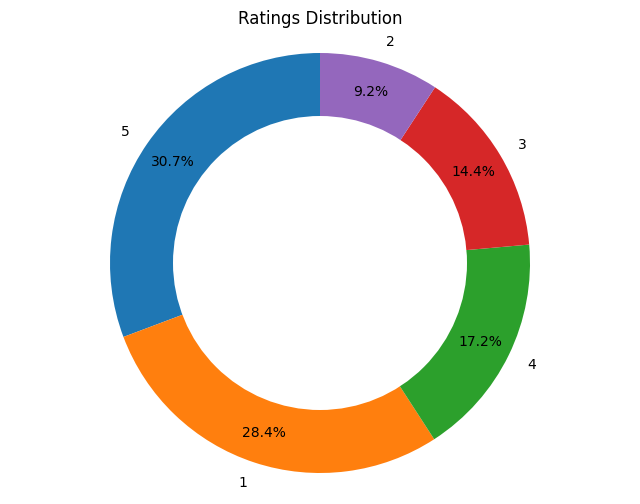

In [16]:
lbl = md['Stars'].value_counts()

plt.figure(figsize=(8,6))
plt.pie(lbl, labels=lbl.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.title('Ratings Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()

In [17]:
def cl_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = re.sub(r'\s+', ' ', review).strip()

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review)
    review = ' '.join([word for word in review_tokens if word not in stop_words])

   
    return review

md['cl_reviews'] = md['review'].apply(cl_review)

print(md[['cl_reviews']])

                                              cl_reviews
0      look like someone spit food normal transaction...
1      itd mcdonalds far food atmosphere go staff mak...
2      made mobile order got speaker checked line mov...
3      mc crispy chicken sandwich customer service qu...
4      repeat order times drive thru still manage mes...
...                                                  ...
33391                                      treated badly
33392                                       service good
33393                               remove hunger enough
33394                       good lately become expensive
33395                                     took good care

[32736 rows x 1 columns]


In this step, I have defined a function for processing of text. I have defined several tasks for the function. First I have converted the text to lowercase and then I have removed the non-alpahbetic characters. After this I have removed the extra whitespaces from the reviews and removed the most common English stopwords. Then eventually I have applied this function to the 'review' column and created a new 'cl_review' column which will contain the cleaned reviews. After this I have dropped the 'review' column from the dataset.

In [18]:
md = md.drop(columns=['review'])

#### Sentiment Analysis

In [19]:
anlyzr = SentimentIntensityAnalyzer()

md['senti_score'] = md['cl_reviews'].apply(lambda text: anlyzr.polarity_scores(text)['compound'])

md['senti'] = md['senti_score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(md[['cl_reviews', 'senti_score', 'senti']].head())

                                          cl_reviews  senti_score     senti
0  look like someone spit food normal transaction...       0.5541  positive
1  itd mcdonalds far food atmosphere go staff mak...       0.8591  positive
2  made mobile order got speaker checked line mov...      -0.2960  negative
3  mc crispy chicken sandwich customer service qu...       0.0000   neutral
4  repeat order times drive thru still manage mes...      -0.7184  negative


In this step, I have used the SentimentIntensityAnalyzer to calculate the sentiment of texts from the cleaned reviews. After this I have classified the reviews as positive, negative and neutral on the basis of compound score. Finally, I have shown the output of this program which shows the sentiment score and sentiment.

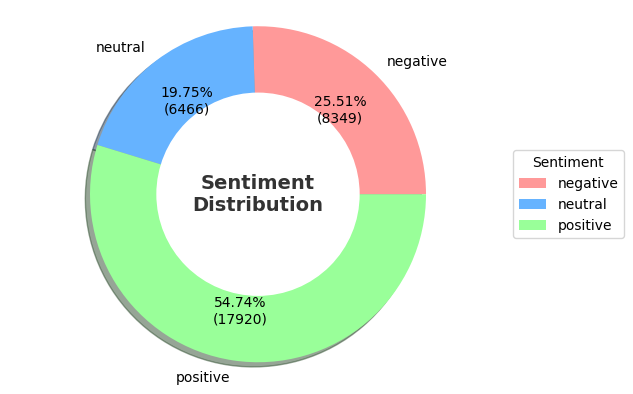

In [20]:
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.0, 0, 0)  
senti_counts = md.groupby("senti").size()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    x=senti_counts, 
    labels=senti_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(senti_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)
ct_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(ct_circle)
ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')
ax.legend(senti_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.axis('equal')  
plt.show()

From the chart, we can see that the positive reviews have the highest contribution, followed by negative reviews and lowest being the neutral reviews.

In [21]:
md['tmp_list'] = md['cl_reviews'].apply(lambda x: str(x).split())
p_sent = md[md['senti'] == 'positive']
neg_sent = md[md['senti'] == 'negative']
nel_sent = md[md['senti'] == 'neutral']

#### Words in Positive Sentiment

In [22]:
tp = Counter([item for sublist in md[md['senti'] == 'positive']['tmp_list'] for item in sublist])
pve = pd.DataFrame(tp.most_common(15), columns=['Common_words', 'count'])
pve.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,5071
1,food,4409
2,service,3388
3,mcdonalds,3349
4,excellent,2518
5,order,2448
6,great,2169
7,place,2008
8,clean,1795
9,fast,1770


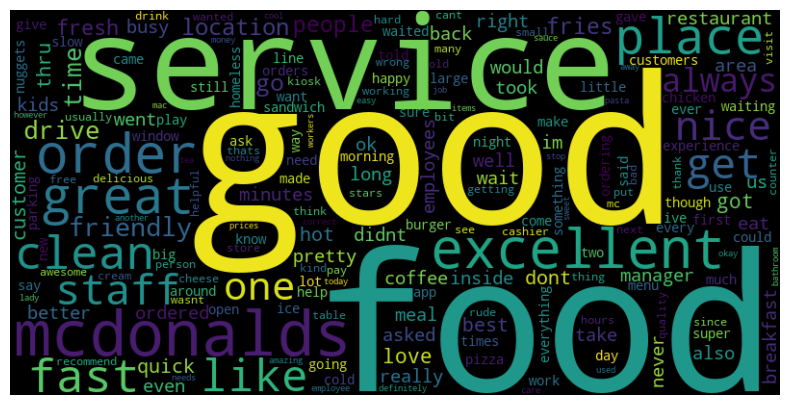

In [23]:
tp = Counter([item for sublist in md[md['senti'] == 'positive']['tmp_list'] for item in sublist])
pve = pd.DataFrame(tp.most_common(), columns=['Common_words', 'count'])
wcd_data = pve.set_index('Common_words')['count'].to_dict()
wd = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(wcd_data)
plt.figure(figsize=(10, 5))
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Words in Neutral Sentiment

In [24]:
tp = Counter([item for sublist in md[md['senti'] == 'neutral']['tmp_list'] for item in sublist])
nrl = pd.DataFrame(tp.most_common(15), columns=['Common_words', 'count'])
nrl.style.background_gradient(cmap='Blues')

,Common_words,count
0,neutral,942
1,food,845
2,mcdonalds,764
3,order,677
4,service,629
5,fast,552
6,drive,518
7,get,403
8,slow,381
9,thru,348


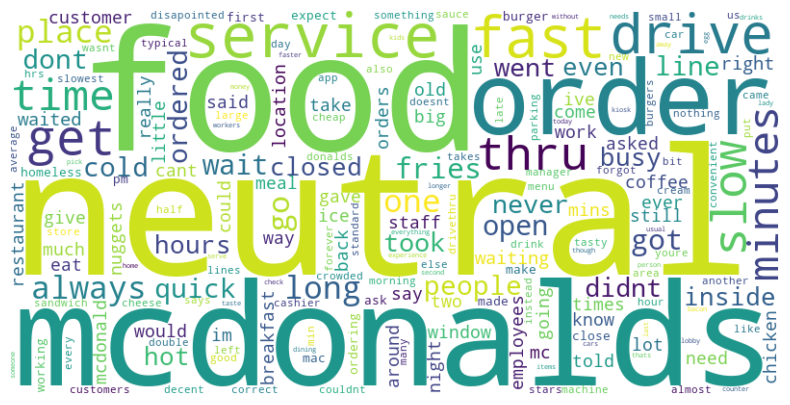

In [25]:
tp = Counter([item for sublist in md[md['senti'] == 'neutral']['tmp_list'] for item in sublist])
nrl = pd.DataFrame(tp.most_common(), columns=['Common_words', 'count'])
wcd_data = nrl.set_index('Common_words')['count'].to_dict()
wd = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wcd_data)

plt.figure(figsize=(10, 5))
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Words in Negative Sentiment

In [26]:
tp = Counter([item for sublist in md[md['senti'] == 'negative']['tmp_list'] for item in sublist])
nve = pd.DataFrame(tp.most_common(15), columns=['Common_words', 'count'])
nve.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,2905
1,food,2362
2,service,2050
3,mcdonalds,1864
4,get,1334
5,drive,1131
6,worst,1088
7,one,1071
8,bad,1059
9,rude,1056


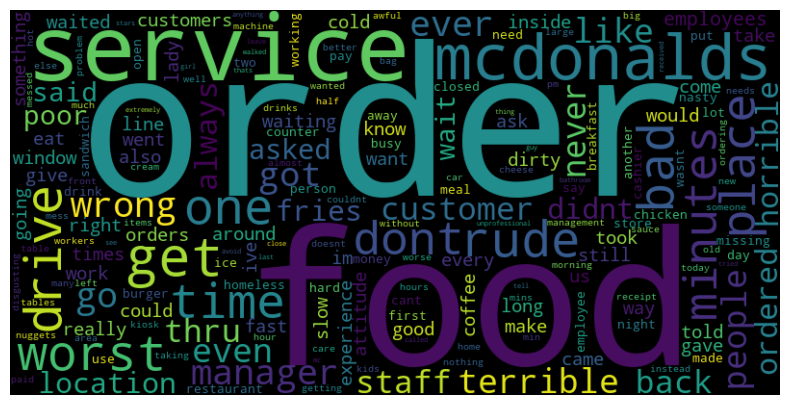

In [27]:
tp = Counter([item for sublist in md[md['senti'] == 'negative']['tmp_list'] for item in sublist])
nve = pd.DataFrame(tp.most_common(), columns=['Common_words', 'count'])
wcd_data = nve.set_index('Common_words')['count'].to_dict()
wd = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(wcd_data)

plt.figure(figsize=(10, 5))
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Defining the input and target variables

In [28]:
S = md['cl_reviews']
K = md['senti']

#### Splitting the Data

In [29]:
S_train, S_test, K_train, K_test = train_test_split(S, K, test_size=0.2, random_state=42)

### Training the Models

#### Bernoulli Naive Bayes Classifier

In [30]:
bl_nb = make_pipeline(TfidfVectorizer(), BernoulliNB())
bl_nb.fit(S_train, K_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('bernoullinb', BernoulliNB())])

In [31]:
bl_nb_pd = bl_nb.predict(S_test)
print("Bernoulli Naive Bayes Classifier:")
print(classification_report(K_test, bl_nb_pd))

Bernoulli Naive Bayes Classifier:
              precision    recall  f1-score   support

    negative       0.66      0.54      0.59      1721
     neutral       0.69      0.76      0.72      1244
    positive       0.84      0.88      0.86      3583

    accuracy                           0.77      6548
   macro avg       0.73      0.73      0.72      6548
weighted avg       0.76      0.77      0.76      6548



#### Multinomial Naive Bayes Classifier

In [32]:
nb_pl = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_pl.fit(S_train, K_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [33]:
nb_pd = nb_pl.predict(S_test)
print("Multinomial Naive Bayes Classifier:")
print(classification_report(K_test, nb_pd))

Multinomial Naive Bayes Classifier:
              precision    recall  f1-score   support

    negative       0.83      0.75      0.79      1721
     neutral       0.98      0.22      0.37      1244
    positive       0.73      0.96      0.83      3583

    accuracy                           0.77      6548
   macro avg       0.85      0.65      0.66      6548
weighted avg       0.81      0.77      0.73      6548



#### Logistic Regression Classifier

In [34]:
lg_pl = make_pipeline(TfidfVectorizer(), LogisticRegression())
lg_pl.fit(S_train, K_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [35]:
lg_pd = lg_pl.predict(S_test)
print("Logistic Regression Classifier:")
print(classification_report(K_test, lg_pd))

Logistic Regression Classifier:
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      1721
     neutral       0.87      0.89      0.88      1244
    positive       0.94      0.95      0.94      3583

    accuracy                           0.91      6548
   macro avg       0.90      0.90      0.90      6548
weighted avg       0.91      0.91      0.91      6548



In [36]:
pa_pl = make_pipeline(TfidfVectorizer(), PassiveAggressiveClassifier())
pa_pl.fit(S_train, K_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('passiveaggressiveclassifier', PassiveAggressiveClassifier())])

In [37]:
pa_pd = pa_pl.predict(S_test)
print("Passive Aggressive Classifier:")
print(classification_report(K_test, pa_pd))

Passive Aggressive Classifier:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      1721
     neutral       0.89      0.91      0.90      1244
    positive       0.94      0.95      0.94      3583

    accuracy                           0.92      6548
   macro avg       0.91      0.91      0.91      6548
weighted avg       0.92      0.92      0.92      6548



#### Support Vector Classifier

In [38]:
svc_pl = make_pipeline(TfidfVectorizer(), SVC())
svc_pl.fit(S_train, K_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [39]:
svc_pd = svc_pl.predict(S_test)
print("Support Vector Classifier:")
print(classification_report(K_test, svc_pd))

Support Vector Classifier:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      1721
     neutral       0.91      0.91      0.91      1244
    positive       0.95      0.96      0.95      3583

    accuracy                           0.93      6548
   macro avg       0.92      0.92      0.92      6548
weighted avg       0.93      0.93      0.93      6548



After training all the models and evaluating all the models, we can see that the accuracy of SVC Model is highest at <b>0.93.<b>

Hence, the best model is <b>Support Vector Classifier.<b>

### Confusion Matrix

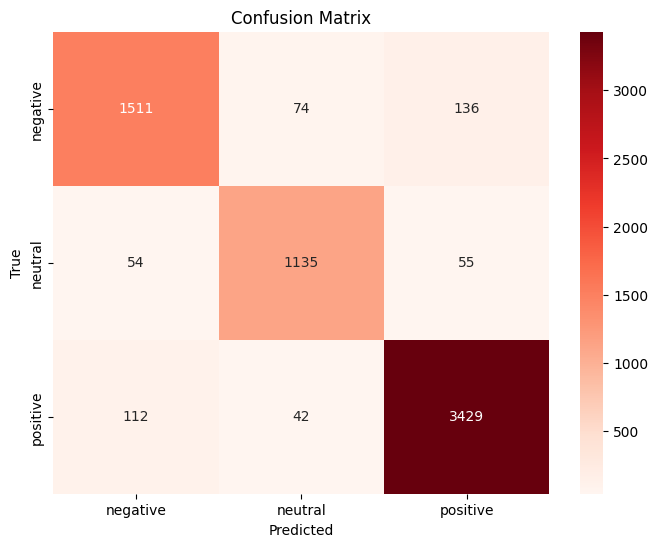

In [40]:
cf_mat = confusion_matrix(K_test, svc_pd)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_mat, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(K_test), yticklabels=np.unique(K_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the heatmap one can observe that, the model is best at predicting positive sentiment. The model predicts 3429 positive values correctly out of 3583. With 1135 correctly predicted out of 1244, this model also performs well at predicting neutral sentiment. But with 1511 accurately predicted out of 1621, the model does not perform that well with negative sentiments.

### Cross Validation

In [41]:
svc_pe = make_pipeline(TfidfVectorizer(), SVC())
cv_scrs = cross_val_score(svc_pe, S_train, K_train, cv=5, scoring='accuracy')

print("Scores of Cross Validation:", cv_scrs)
print("Mean CV Score:", cv_scrs.mean())

Scores of Cross Validation: [0.91504391 0.91618939 0.9163803  0.91674623 0.91674623]
Mean CV Score: 0.9162212100976523


In this program, I have done the cross-validation. Cross-validation helps us to get a trustworthy estimate regarding the performance of model. In this I have combined TfidVectorizer and SVC which performs 5-fold cross-validation to evaluate model accuracy and prints the results.

### Final Discussion

The NLP pipeline which is implemented here is sucessful in processing and analyzing customer reviews. It helps us provide valuable insights regarding sentiments of customer. The strengths of this pipeline are it provides automated analysis, actionable insights and scalability. However, it has some limitations which are lack of contextual understanding and dependency on data quality must be considered. Timely updates and the inclusion of more advanced models can improve the pipeline. Also the integration of CRM systems are must for long term benefits.

By adopting this NLP pipeline, McDonald's can extract the sentiments of customers from reviews and bring insights in several ways:

<b>Service Issue Identification</b>: Identify recurring issues quickly, across geographies.

<b>Customer Satisfaction</b>: Quickly address negative feedback to improve the overall customer experience.

<b>Long-term Decisions</b: Based on trends in customer feedback, make an informed decision.

Market Analysis: Clearly understand performance at different locations and identify best practices.